## <p style="background-color:#ff9944; font-family:calibri; font-size:120%; color:white; text-align:center; border-radius:30px 30px 30px 30px / 30px 30px 30px 30px  ; padding:20px;width: 50%;margin: 0 auto;">Import Libraries</p> 

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install supervision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.9/515.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
import torch

import supervision as sv
from datetime import timedelta

## <p style="background-color:#ff9944; font-family:calibri; font-size:120%; color:white; text-align:center; border-radius:30px 30px 30px 30px / 30px 30px 30px 30px  ; padding:20px;width: 50%;margin: 0 auto;">Load YOLO model</p> 

In [6]:
model=YOLO('yolov8s.pt')

  0%|          | 0.00/21.5M [00:00<?, ?B/s]

<div style="border-radius:10px 10px; border: #ff9944 solid; padding: 15px; font-size:110%; text-align:left">

This line of code initializes an instance of the YOLO class using the 'yolov8s.pt' pre-trained model.





## <p style="background-color:#ff9944; font-family:calibri; font-size:120%; color:white; text-align:center; border-radius:30px 30px 30px 30px / 30px 30px 30px 30px  ; padding:20px;width: 50%;margin: 0 auto;">Check GPU is working or not</p> 

In [7]:

import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 1.13.0 (Tesla P100-PCIE-16GB)


## <p style="background-color:#ff9944; font-family:calibri; font-size:120%; color:white; text-align:center; border-radius:30px 30px 30px 30px / 30px 30px 30px 30px  ; padding:20px;width: 50%;margin: 0 auto;">Open the video file</p>

In [8]:
cap=cv2.VideoCapture('/kaggle/input/parking-area/parking_area/park.mp4')


## <p style="background-color:#ff9944; font-family:calibri; font-size:120%; color:white; text-align:center; border-radius:30px 30px 30px 30px / 30px 30px 30px 30px  ; padding:20px;width: 50%;margin: 0 auto;">Video Information Extraction</p>

In [9]:
def get_video_info(video_path):
    
    # Extracting information about the video
    video_info = sv.VideoInfo.from_video_path(video_path)
    width, height, fps, total_frames = video_info.width, video_info.height, video_info.fps, video_info.total_frames
    
    # Calculating the length of the video by dividing the total number of frames by the frame rate and rounding to the nearest second
    video_length = timedelta(seconds = round(total_frames / fps))
    
    # Print out the video resolution, fps, and length u
    print(f"\033[1mVideo Resolution:\033[0m ({width}, {height})")
    print(f"\033[1mFPS:\033[0m {fps}")
    print(f"\033[1mLength:\033[0m {video_length}")

In [10]:
# Extracting information of the test video
get_video_info('/kaggle/input/parking-area/parking_area/park.mp4')

Video Resolution: (1920, 1080)
FPS: 50
Length: 0:00:24


## <p style="background-color:#ff9944; font-family:calibri; font-size:120%; color:white; text-align:center; border-radius:30px 30px 30px 30px / 30px 30px 30px 30px  ; padding:20px;width: 50%;margin: 0 auto;">Open the COCO dataset file</p>

In [11]:
my_file = open("/kaggle/input/parking-area/parking_area/coco.txt", "r")
data = my_file.read()
class_list = data.split("\n")
#print(class_list)
count=0


## <p style="background-color:#ff9944; font-family:calibri; font-size:120%; color:white; text-align:center; border-radius:30px 30px 30px 30px / 30px 30px 30px 30px  ; padding:20px;width: 80%;margin: 0 auto;">Object Detection in a Region of Interest using YOLO Model</p>

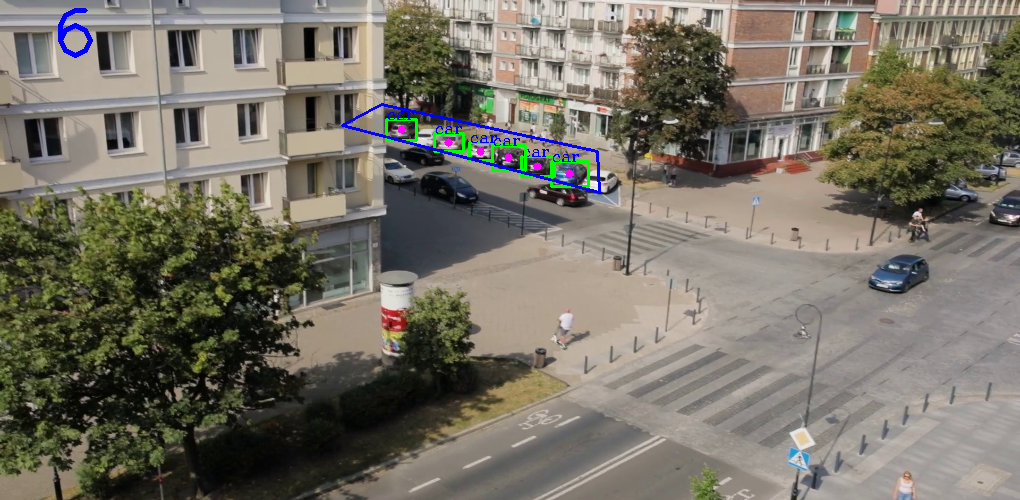

In [12]:
import cv2
import pandas as pd
import numpy as np
from IPython.display import clear_output
from PIL import Image

# Define the area of interest polygon (top-left, bottom-left, bottom-right, top-right)
area = [(381,104),(342,125),(599,192),(597,151)]

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/kaggle/working/output.mp4', fourcc, 30.0, (1020, 500))

# Loop over the frames of the video
while True:    
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    
    # Process every third frame to reduce processing load
    if count % 3 != 0:
        continue
    # Skip frames with no data
    if frame is None or frame.shape[0] == 0 or frame.shape[1] == 0:
        continue
    # Resize the frame for faster processing
    frame = cv2.resize(frame, (1020, 500))
    
    # Predict the objects in the frame with YOLO model
    results = model.predict(frame)
    a = results[0].boxes.data
    px = pd.DataFrame(a.cpu().numpy()).astype('float')
    car_list = []
    # Loop over the detected objects
    for index, row in px.iterrows(): 
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        
        # Check if the detected object is a car and is inside the area of interest
        if 'car' in c:
            cx = int(x1 + x2) // 2 
            cy = int(y1 + y2) // 2 
            results = cv2.pointPolygonTest(np.array(area, np.int32), ((cx, cy)), False)  
            if results >= 0:
                # Draw a rectangle around the car, a circle on its centroid, and its class name
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.circle(frame, (cx, cy), 4, (255, 0, 255), -1) 
                cv2.putText(frame, str(c), (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0), 1) 
                car_list.append([c])
    # Draw the area of interest polygon and the number of detected cars in the frame         
    cv2.polylines(frame, [np.array(area, np.int32)], True, (255, 0, 2), 2) 
    k = len(car_list)  
    cv2.putText(frame, str(k), (50, 60), cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), 3) 
    clear_output(wait=True)
    display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
    out.write(frame)
    # Exit the loop when 'ESC' key is pressed
    if cv2.waitKey(1) & 0xFF == 27:  
        break
# Release the video file and close all windows        
cap.release()
out.release()
cv2.destroyAllWindows()